In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import os
import sys
import pickle
# Add the function directory to the path
sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/functions/')
from Slicing import Slicing
from fio import readin
from TurStat import TurStat
from tqdm import tqdm
from visualization import contour_generator

Text(0.5, 0, 'kx')

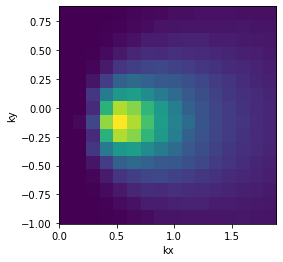

In [19]:
'''
    Initialization based on PM/Jonswap.
    All identities with _tile are two-dimensional array.
    In principle kmax = 2*np.pi/(2L/N_grid), kmin=2*np.pi/L.
''' 
# Function to convert polar to cartesian and interpolate
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

# Spectrum in polar coordinate
kp = 2*np.pi/10 # peak at 10m
P = 0.02
N_power = 5;  thetam = 0
N_kmod = 64; N_theta = 64 # Uniform grid in kmod and ktheta
kmod = np.linspace(0.2,4,N_kmod); theta = np.linspace(-0.5*np.pi, 0.5*np.pi, N_theta)
kmod_tile, theta_tile = np.meshgrid(kmod,theta)
# F_kmod = P*kmod**(-2.5)*np.exp(-0.75*(kp/kmod)**2)
F_kmod = P*kmod**(-2.5)*np.exp(-0.75*(kp/kmod)**2)
D_theta = np.cos(theta-thetam)**N_power
D_theta = D_theta/np.trapz(D_theta, theta) # Normalize so the sum equals one
F_kmod_tile, D_theta_tile = np.meshgrid(F_kmod,D_theta) # Direct metrix multiplication in python
F_kmodtheta_tile = F_kmod_tile*D_theta_tile

# Project onto kx,ky
N_mode = 16; L =50
kx = np.arange(0,N_mode,1)*2*np.pi/L # based on the grid, interval can't go smaller then pi/L
ky = np.arange(-N_mode/2,N_mode/2,1)*2*np.pi/L
dkx = kx[1]-kx[0]; dky = ky[1]-ky[0]
kx_tile, ky_tile = np.meshgrid(kx,ky)
kxp_tile, kyp_tile = pol2cart(kmod_tile, theta_tile)
from scipy.interpolate import LinearNDInterpolator, griddata
F_kxky_tile = griddata((kxp_tile.ravel(),kyp_tile.ravel()), F_kmodtheta_tile.ravel(), (kx_tile, ky_tile), 
                       method='nearest')
# interpolator = LinearNDInterpolator((kxp_tile.ravel(),kyp_tile.ravel()), F_kmodtheta_tile.ravel())
# F_kxky_tile = interpolator(kx_tile, ky_tile) 
plt.imshow(F_kxky_tile, extent=[kx_tile[0,0],kx_tile[-1,-1],ky_tile[0,0],ky_tile[-1,-1]])
plt.ylabel('ky'); plt.xlabel('kx')
# plt.plot(kmod, F_kmod, '.')
# plt.ylabel('F(k)'); plt.xlabel('k')

In [20]:
'''
    Add modes together to generate initial eta field. Random phase.
'''
N_grid = 256
x = np.linspace(-L/2,L/2,N_grid); y = np.linspace(-L/2,L/2,N_grid)
x_tile, y_tile = np.meshgrid(x, y)
kmod_cart_tile, theta_cart_tile = cart2pol(kx_tile,ky_tile)
omega_tile = (9.8*kmod_cart_tile)**0.5 # frequency based on kx or kmod
# This is the only place that the random field is generated, everything else should agree;
# and we want to seed the random number
def eta_random(t):
    global N_grid, kx_tile, ky_tile, F_kxky_tile, dkx, dky, omega_title
    np.random.seed(3) 
    tb = 40; xb = 0; yb = 0
    phase_tile = -kx_tile*xb-ky_tile*yb+omega_tile*tb+np.random.random_sample(kx_tile.shape)*5 # Add a random phase field
    eta_tile = np.zeros(x_tile.shape)
    for i1 in range(0,N_grid):
        for i2 in range(0,N_grid):
            ampl = (2*F_kxky_tile*dkx*dky)**0.5
            # How to exactly represent integrate over dk_x*dk_y*eta_hat?
            # mode = (F_kdirectional**0.5)*np.cos((kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])+
            #                                    phase_tile)*(kmod_tile*(kmod[1]-kmod[0])*(theta[1]-theta[0])) # uniform space in k and theta
            a = (kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])-omega_tile*t+phase_tile
            mode = ampl*(np.cos(a)) # uniform spacing in kx and ky
            eta_tile[i1,i2] = np.sum(mode)    
    return eta_tile,phase_tile

In [11]:
'''
    Add modes together to generate initial eta field.
    Phase not random but focusing.
'''
# This is the only place that the random field is generated, everything else should agree;
# and we want to seed the random number
def eta_focusing(t):
    global N_grid, kx_tile, ky_tile, F_kxky_tile, dkx, dky, omega_title
    tb = 40; xb = 0; yb = 0 # travelling at group velocity?
    phase_tile = -kx_tile*xb-ky_tile*yb+omega_tile*tb
    # phase_tile = np.random.random_sample(kx_tile.shape)*2*np.pi # Add a random phase field
    # x = np.linspace(-L/2,L/2+L/N_grid,N_grid+1,endpoint=False)+L/N_grid/2; y = np.linspace(-L/2,L/2,N_grid,endpoint=False)+L/N_grid/2
    x = np.linspace(-L/2,L/2,N_grid,endpoint=False)+L/N_grid/2 # So that interpolation does not have nan
    y = np.linspace(-L/2,L/2,N_grid,endpoint=False)+L/N_grid/2
    x_tile, y_tile = np.meshgrid(x, y)
    eta_tile = np.zeros(x_tile.shape)
    t = 0
    for i1 in range(0,N_grid):
        for i2 in range(0,N_grid):
            ampl = (2*F_kxky_tile*dkx*dky)**0.5
            a = (kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])-omega_tile*t+phase_tile
            mode = ampl*(np.cos(a)) # uniform space in kx and ky
            eta_tile[i1,i2] = np.sum(mode)  
    return eta_tile,phase_tile

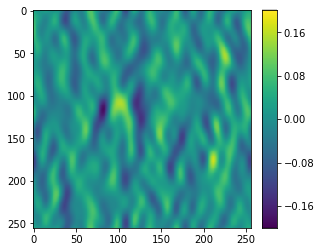

In [22]:
# How to speed up matplotlib
# https://stackoverflow.com/questions/8955869/why-is-plotting-with-matplotlib-so-slow
from matplotlib import animation
from visualization import contour
from IPython.display import HTML
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.image as mpimg

# Single animation generation function
def plot_animation(animate_function, frame_number = 31, interval_time = 100):

    # First set up the figure, the axis, and the plot element we want to animate    
    fig,ax = contour_generator()
    pcontour = ax[0].imshow(eta_tile*kp, vmax=0.2, vmin=-0.2)
    ax[0].cax.colorbar(pcontour)

    # animation function.  This is called sequentially
    def animate(i):
        t = i*2
        imgplot = animate_function(i, ax[0])
        return imgplot,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, frames=frame_number, interval=interval_time, blit = True)  
    return anim

# Define the function called at every animation time to read in images
def plot_func(i, ax):
    t = i
    eta_tile = eta_random(t)
    image = ax.imshow(eta_tile*kp, vmax=0.2, vmin=-0.2)
    return image

anim = plot_animation(plot_func, frame_number = 100, interval_time = 100) # Specify frame number
HTML(anim.to_html5_video())

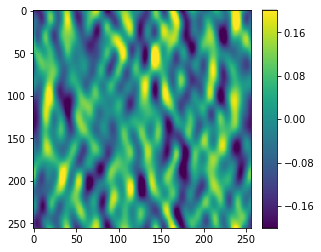

In [21]:
fig,grid = contour_generator()
eta_tile,phase_tile = eta_random(0)
pcontour = grid[0].imshow(eta_tile*kp, vmax=0.2, vmin=-0.2)
grid[0].cax.colorbar(pcontour)

In [15]:
'''
    Check that calculation of F(kmod) is consistent by comparing integration of F(kmod) and mean square
    of the initial eta field.
'''
dx = L/N_grid
F_integrated = np.sum(F_kxky_tile)*((kx[1]-kx[0])*(ky[1]-ky[0])) # Integration over kx ky is easier
print(F_integrated)
print(np.sum((eta_tile-np.average(eta_tile))**2)/(L**2)*dx*dx)# Notice the Delta x normalization
print(np.std(eta_tile)*kp)
print(np.average(eta_tile))

0.010448160228107708
0.010453551559444219
0.06424092729035133
-0.0001739720049890572


In [22]:
'''
    Output eta to file
'''
eta_tile,phase_tile = eta_random(0)
feta = open("/home/jiarong/research/projects/multilayer/testing/multigrid_changeheader/trial26/pre/eta", 'bw')
eta_output = eta_tile.astype('float32'); eta_output.tofile(feta)

In [489]:
'''
    Interpolate onto a higher level grid without introducing more higher wavenumber modes.
    Output to file.
'''
RATIO = 8
x_higher = np.linspace(-L/2,L/2,N_grid*RATIO,endpoint=False)+L/(N_grid*RATIO)/2;
y_higher = np.linspace(-L/2,L/2,N_grid*RATIO,endpoint=False)+L/(N_grid*RATIO)/2;
x_tile_higher,y_tile_higher = np.meshgrid(x_higher, y_higher)
from scipy.interpolate import RegularGridInterpolator
eta_tile_higher = griddata((x_tile.ravel(),y_tile.ravel()), eta_tile.ravel(), (x_tile_higher, y_tile_higher), 
                       method='linear')
feta = open("/home/jiarong/research/projects/multilayer/testing/multigrid_changeheader/trial11/pre/eta", 'bw')
eta_output = eta_tile_higher.astype('float32'); eta_output.tofile(feta)

In [477]:
'''
    Check that calculation of F(kmod) is consistent by comparing integration of F(kmod) and mean square
    of the initial eta field.
'''
RATIO=8
dx = L/(N_grid*RATIO)
F_integrated = np.sum(F_kxky_tile)*((kx[1]-kx[0])*(ky[1]-ky[0])) # Integration over kx ky is easier
print(F_integrated)
print(np.sum((eta_tile_higher-np.average(eta_tile_higher))**2)/(L**2)*dx*dx)# Notice the Delta x normalization
print(np.std(eta_tile_higher)*kp)
print(np.average(eta_tile_higher))

1.9616173814452048e-07
0.004315514114494719
0.041275860789270195
-0.0034079938128778013


In [ ]:
'''
    A second way of initializing velocity. Adding an actual z option. 
'''
eta_tile, phase_tile = eta_random(0)
zb = -5; z_tile = zb*np.ones(x_tile.shape) # computational domain bottom position
N_layer = 30 # Number of layers used 
h_tile = eta_tile/N_layer # height of each layer (uniformly divided)
g = 9.8
u_tile = np.zeros(x_tile.shape); v_tile = np.zeros(x_tile.shape); w_tile = np.zeros(x_tile.shape)
u_set = []; v_set = []; w_set = []; z_set=[] # For sanity checks
kmod_cart_tile, theta_cart_tile = cart2pol(kx_tile,ky_tile) # The module of k from kx_tile and ky_tile
for l in tqdm(range(0, N_layer)):
    u_tile, v_tile, w_tile = np.zeros(x_tile.shape), np.zeros(x_tile.shape), np.zeros(x_tile.shape)
    z_tile = z_tile + (eta_tile-zb)/N_layer/2
    for i1 in range(0,N_grid):
        for i2 in range(0,N_grid):
            ampl = (2*F_kxky_tile*dkx*dky)**0.5
            actual_z_tile = np.minimum(ampl, np.ones(ampl.shape)*z_tile[i1,i2]) # Element wise comparison
            a = (kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])+phase_tile
            mode = ampl*(np.cos(a))
            # u = \sqrt{gk}*A*sin(kx-wt), but also need to consider direction cos(theta)
            u_mode = (g*kmod_cart_tile)**0.5*ampl*np.exp(kmod_cart_tile*actual_z_tile)*np.cos(a)*np.cos(theta_cart_tile)
            v_mode = (g*kmod_cart_tile)**0.5*ampl*np.exp(kmod_cart_tile*actual_z_tile)*np.cos(a)*np.sin(theta_cart_tile)
            w_mode = (g*kmod_cart_tile)**0.5*ampl*np.exp(kmod_cart_tile*actual_z_tile)*np.sin(a)
            u_tile[i1,i2] = np.sum(u_mode); v_tile[i1,i2] = np.sum(v_mode); w_tile[i1,i2] = np.sum(w_mode)
    u_set.append(u_tile); v_set.append(v_tile); w_set.append(w_tile); z_set.append(z_tile)
    fu = open("/home/jiarong/research/projects/multilayer/testing/multigrid_changeheader/trial26/pre/u_layer%g" %l, "bw")
    u_output = u_tile.astype('float32'); u_output.tofile(fu)
    fv = open("/home/jiarong/research/projects/multilayer/testing/multigrid_changeheader/trial26/pre/v_layer%g" %l, "bw")
    v_output = v_tile.astype('float32'); v_output.tofile(fv)
    fw = open("/home/jiarong/research/projects/multilayer/testing/multigrid_changeheader/trial26/pre/w_layer%g" %l, "bw")
    w_output = w_tile.astype('float32'); w_output.tofile(fw)
    z_tile = z_tile + (eta_tile-zb)/N_layer/2

 70%|███████   | 21/30 [02:04<00:53,  6.00s/it]

In [488]:
'''
    A second way of initializing velocity. Adding an actual z option. 
    Interpolate onto a higher level grid without introducing more higher wavenumber modes.
'''
zb = -5; z_tile = zb*np.ones(x_tile.shape) # computational domain bottom position
N_layer = 15 # Number of layers used 
h_tile = eta_tile/N_layer # height of each layer (uniformly divided)
g = 9.8
u_tile = np.zeros(x_tile.shape); v_tile = np.zeros(x_tile.shape); w_tile = np.zeros(x_tile.shape)
u_set = []; v_set = []; w_set = []; z_set=[] # For sanity checks
kmod_cart_tile, theta_cart_tile = cart2pol(kx_tile,ky_tile) # The module of k from kx_tile and ky_tile
for l in tqdm(range(0, N_layer)):
    u_tile, v_tile, w_tile = np.zeros(x_tile.shape), np.zeros(x_tile.shape), np.zeros(x_tile.shape)
    z_tile = z_tile + (eta_tile-zb)/N_layer/2
    for i1 in range(0,N_grid):
        for i2 in range(0,N_grid):
            ampl = (2*F_kxky_tile*dkx*dky)**0.5
            actual_z_tile = np.minimum(ampl, np.ones(ampl.shape)*z_tile[i1,i2]) # Element wise comparison
            a = (kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])+phase_tile
            mode = ampl*(np.cos(a))
            # u = \sqrt{gk}*A*sin(kx-wt), but also need to consider direction cos(theta)
            u_mode = (g*kmod_cart_tile)**0.5*ampl*np.exp(kmod_cart_tile*actual_z_tile)*np.cos(a)*np.cos(theta_cart_tile)
            v_mode = (g*kmod_cart_tile)**0.5*ampl*np.exp(kmod_cart_tile*actual_z_tile)*np.cos(a)*np.sin(theta_cart_tile)
            w_mode = (g*kmod_cart_tile)**0.5*ampl*np.exp(kmod_cart_tile*actual_z_tile)*np.sin(a)
            u_tile[i1,i2] = np.sum(u_mode); v_tile[i1,i2] = np.sum(v_mode); w_tile[i1,i2] = np.sum(w_mode)
    u_tile_higher = griddata((x_tile.ravel(),y_tile.ravel()), u_tile.ravel(), (x_tile_higher, y_tile_higher), method='linear')
    v_tile_higher = griddata((x_tile.ravel(),y_tile.ravel()), v_tile.ravel(), (x_tile_higher, y_tile_higher), method='linear')
    w_tile_higher = griddata((x_tile.ravel(),y_tile.ravel()), w_tile.ravel(), (x_tile_higher, y_tile_higher), method='linear')
    u_set.append(u_tile_higher); v_set.append(v_tile_higher); w_set.append(w_tile_higher); z_set.append(z_tile)
    fu = open("/home/jiarong/research/projects/multilayer/testing/multigrid_changeheader/trial11/pre/u_layer%g" %l, "bw")
    u_output = u_tile_higher.astype('float32'); u_output.tofile(fu)
    fv = open("/home/jiarong/research/projects/multilayer/testing/multigrid_changeheader/trial11/pre/v_layer%g" %l, "bw")
    v_output = v_tile_higher.astype('float32'); v_output.tofile(fv)
    fw = open("/home/jiarong/research/projects/multilayer/testing/multigrid_changeheader/trial11/pre/w_layer%g" %l, "bw")
    w_output = w_tile_higher.astype('float32'); w_output.tofile(fw)
    z_tile = z_tile + (eta_tile-zb)/N_layer/2

100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


1.0216970528634024


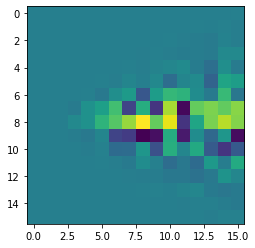

In [290]:
i1 = 5; i2 = 5
z_tile = zb*np.ones(x_tile.shape)+4.75
ampl = (2*F_kxky_tile*dkx*dky)**0.5
a = (kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])+phase_tile
mode = ampl*(np.cos(a))
u_mode = (g*kmod_cart_tile)**0.5*ampl*np.exp(kmod_cart_tile*z_tile[i1,i2])*np.cos(a)*np.cos(theta_cart_tile)
plt.imshow(u_mode)
print(np.sum(u_mode))

In [398]:
'''
    Check KE and GPE equal partition.
'''
# To do: compute gpe from z_set
# Energy/area

gpe = 0.5*np.sum(eta_tile**2)*(1/(N_grid*RATIO))**2*9.8
print(gpe)
ke = 0
gpe_int = 0
for ilayer in range(0,N_layer):
    # Kinetic energy is integrated along the depth thus zb/N_layer
    ke += (np.sum(u_set[ilayer]**2)+np.sum(v_set[ilayer]**2)+np.sum(w_set[ilayer]**2))*(1/(N_grid*RATIO))**2*(0-zb)/N_layer
    gpe_int += np.sum(z_set[ilayer])*(1/(N_grid*RATIO))**2*(0-zb)/N_layer
ke = 0.5*ke
print(ke)
gpe_baseline = 0.5*zb**2
print((gpe_int-gpe_baseline)*9.8)

5.404912310222482e-06
8.882592243842491e-05
-124.66086513157235


In [328]:
'''
    Check KE and GPE equal partition. For the interpolated cases.
'''
# To do: compute gpe from z_set
# Energy/area

gpe = 0.5*np.sum(eta_tile_higher**2)*(1/(N_grid*RATIO))**2*9.8
print(gpe)
ke = 0
gpe_int = 0
for ilayer in range(0,N_layer):
    # Kinetic energy is integrated along the depth thus zb/N_layer
    ke += (np.sum(u_set[ilayer]**2)+np.sum(v_set[ilayer]**2)+np.sum(w_set[ilayer]**2))*(1/(N_grid*RATIO))**2*(0-zb)/N_layer
    gpe_int += np.sum(z_set[ilayer])*(1/(N_grid*RATIO))**2*(0-zb)/N_layer
ke = 0.5*ke
print(ke)

0.10593775000614174
0.1015899193199743


In [ ]:
'''
    Initialize the velocity field by adding modes together. The previous version.
'''
zb = -5; z_tile = zb*np.ones(x_tile.shape) # computational domain bottom position
N_layer = 5 # Number of layers used 
h_tile = eta_tile/N_layer # height of each layer (uniformly divided)
g = 9.8
u_tile = np.zeros(x_tile.shape); v_tile = np.zeros(x_tile.shape); w_tile = np.zeros(x_tile.shape)
u_set = []; v_set = []; w_set = []; z_set=[] # For sanity checks
kmod_cart_tile, theta_cart_tile = cart2pol(kx_tile,ky_tile) # The module of k from kx_tile and ky_tile
for l in tqdm(range(0, N_layer)):
    u_tile, v_tile, w_tile = np.zeros(x_tile.shape), np.zeros(x_tile.shape), np.zeros(x_tile.shape)
    z_tile = z_tile + (eta_tile-zb)/N_layer/2
    for i1 in range(0,N_grid):
        for i2 in range(0,N_grid):
            ampl = (2*F_kxky_tile*dkx*dky)**0.5
            a = (kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])+phase_tile
            mode = ampl*(np.cos(a))
            # u = \sqrt{gk}*A*sin(kx-wt), but also need to consider direction cos(theta)
            u_mode = (g*kmod_cart_tile)**0.5*ampl*np.exp(kmod_cart_tile*z_tile[i1,i2])*np.cos(a)*np.cos(theta_cart_tile)
            v_mode = (g*kmod_cart_tile)**0.5*ampl*np.exp(kmod_cart_tile*z_tile[i1,i2])*np.cos(a)*np.sin(theta_cart_tile)
            w_mode = (g*kmod_cart_tile)**0.5*ampl*np.exp(kmod_cart_tile*z_tile[i1,i2])*np.sin(a)
            u_tile[i1,i2] = np.sum(u_mode); v_tile[i1,i2] = np.sum(v_mode); w_tile[i1,i2] = np.sum(w_mode)
    u_set.append(u_tile); v_set.append(v_tile); w_set.append(w_tile); z_set.append(z_tile)
    fu = open("/home/jiarong/research/projects/multilayer/testing/multigrid_5layer_256/pre/u_layer%g" %l, "bw")
    u_output = u_tile.astype('float32'); u_output.tofile(fu)
    fv = open("/home/jiarong/research/projects/multilayer/testing/multigrid_5layer_256/pre/v_layer%g" %l, "bw")
    v_output = v_tile.astype('float32'); v_output.tofile(fv)
    fw = open("/home/jiarong/research/projects/multilayer/testing/multigrid_5layer_256/pre/w_layer%g" %l, "bw")
    w_output = w_tile.astype('float32'); w_output.tofile(fw)
    z_tile = z_tile + (eta_tile-zb)/N_layer/2

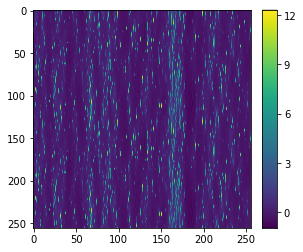

In [18]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10,4))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,1),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
z_tile = zb*np.ones(x_tile.shape)+(eta_tile-zb)/5*4.5
pcontour = grid[0].imshow(u_set[4])
grid[0].cax.colorbar(pcontour)

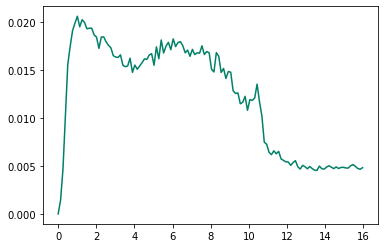

In [90]:
'''
    Plot the initial F(kmod).
    Check shape and peak.
'''
L = 50; N = 256; i=0
spectrum = np.fft.fft2(eta_tile_higher)*(1/N)**2 # How to normalize here?!
F = np.absolute(spectrum)
F_center = np.fft.fftshift(F)
wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
kx = np.fft.fftshift(wavenumber)
ky = kx
kx_tile, ky_tile = np.meshgrid(kx,ky)
theta = np.arange(-N/4,N/4)/(N)*2*np.pi
k = wavenumber[0:int(N/2)]
k_tile, theta_tile = np.meshgrid(k,theta)
kxp_tile, kyp_tile = pol2cart(k_tile, theta_tile)
from scipy import interpolate
f = interpolate.RectBivariateSpline(kx, ky, F_center)
F_center_polar = f.ev(kxp_tile, kyp_tile)
F_center_polar_integrated = np.sum(F_center_polar, axis=0)*(theta[1]-theta[0])*k
plt.plot(k[0:int(N/2)],F_center_polar_integrated*2, color=plt.cm.get_cmap('summer')(i/18), label='t=%g' %i)

In [508]:
# Remaining problem
# 1. "ampl = (2*F_kxky_tile*dkx*dky)**0.5" dxdy inside!
# 2. When integrate to get \eta^2. Why "*dx/L*dy/L"? I think I got that now!
# 3. In the velocity initialization, some tricks.
# Luc's code
# wave2dint=nansum(nansum(wave2d.^2))*dx*dx./L./L
# waveintafterfft3=nanstd(wave3).^2;
# waveintback=nansum(S2(1:N/2))*dk1%yeah!

0.390625

In [21]:
'''
    Output eta to file
'''
feta = open("/home/jiarong/research/projects/multilayer/testing/multigrid_5layer_256/pre/eta", 'bw')
eta_output = eta_tile.astype('float32'); eta_output.tofile(feta)

In [243]:
# Write out a text file for Luc
feta_text = open("/home/jiarong/research/projects/multilayer/testing/ftest_5layer_256/pre/eta_text.dat", "w")
feta_text.write('x y H \n')
for i1 in range(0,256):
    for i2 in range(0,256):
        feta_text.write('%g' %x_tile[i1,i2] + ' ' + '%g' %y_tile[i1, i2] + ' ' + '%g' %eta_tile[i1,i2] + '\n')    

Text(0.5, 0, 'eta')

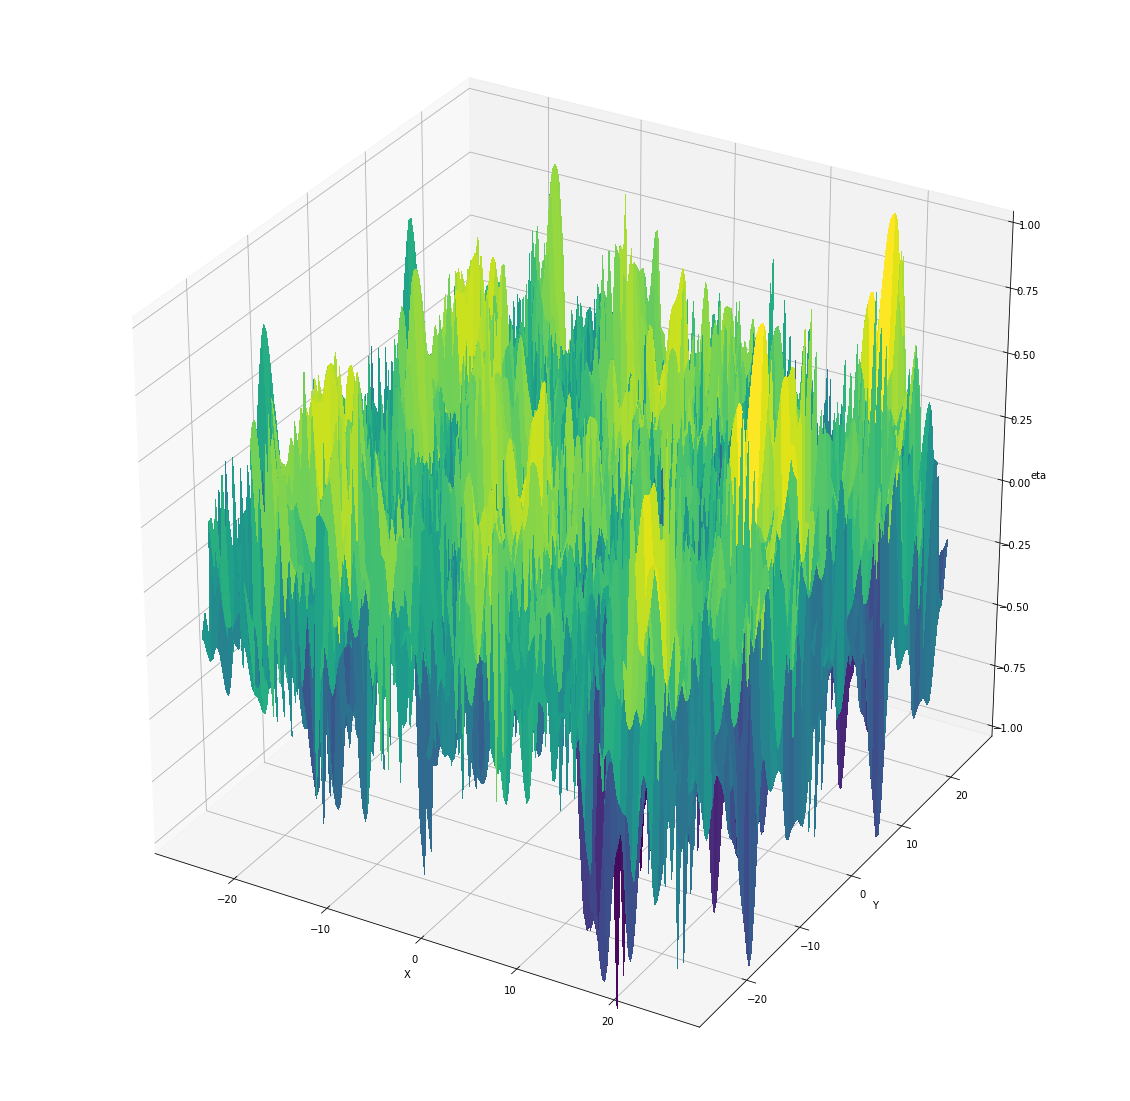

In [633]:
# A 3D plot
fig = plt.figure(figsize=[20,20])
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x_tile, y_tile, eta_tile, cmap='viridis', linewidth=0, antialiased=False)
ax.set_zlim(-1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('eta')

In [280]:
(0.02/26.5)**0.5*26.5

0.7280109889280518